In [15]:
import pennylane as qml
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

X_filtered = X[(y == '3') | (y == '6')]
y_filtered = y[(y == '3') | (y == '6')]

y_filtered = np.where(y_filtered == '3', 0, 1)

In [17]:
pca = PCA()
pca.fit(X_filtered)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance >= 0.50) + 1 

print(f"Number of components to retain 50% variance: {n_components}")

Number of components to retain 50% variance: 8


In [18]:
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_filtered)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_filtered, test_size=0.2, random_state=42)


In [19]:
n_qubit = n_components

dev = qml.device('default.qubit', wires=n_qubit)
@qml.qnode(dev)
def kernel(x1, x2, n_qubit):
    qml.AngleEmbedding(x1, wires=range(n_qubit))
    qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubit))
    return qml.expval(qml.Projector([0]*n_qubit, wires=range(n_qubit)))

In [20]:
def kernel_mat(A, B):
  mat = []
  for a in A:
      row = []
      for b in B:
          row.append(kernel(a, b, n_qubit))
      mat.append(row)
  return np.array(mat)

In [23]:
sizes = np.arange(100, 2001, 100)
accuracies_QML = {}
accuracies_Classical = {}

for size in sizes:
    idx_0 = np.where(y_train == 0)[0]
    idx_1 = np.where(y_train == 1)[0]

    idx_0_sampled = np.random.choice(idx_0, size=size, replace=False)
    idx_1_sampled = np.random.choice(idx_1, size=size, replace=False)

    sampled_indices = np.concatenate([idx_0_sampled, idx_1_sampled])

    X_train_sampled = X_train[sampled_indices]
    y_train_sampled = y_train[sampled_indices]

    #svm_QML = SVC(kernel=kernel_mat)
    #svm_QML.fit(X_train_sampled, y_train_sampled)
    #y_pred_QML = svm_QML.predict(X_test)
    #accuracy_QML = accuracy_score(y_test, y_pred_QML)
    #accuracies_QML[size] = accuracy_QML

    svm_Classical = SVC(kernel='rbf')
    svm_Classical.fit(X_train_sampled, y_train_sampled)
    y_pred_Classical = svm_Classical.predict(X_test)
    accuracy_Classical = accuracy_score(y_test, y_pred_Classical)
    accuracies_Classical[size] = accuracy_Classical


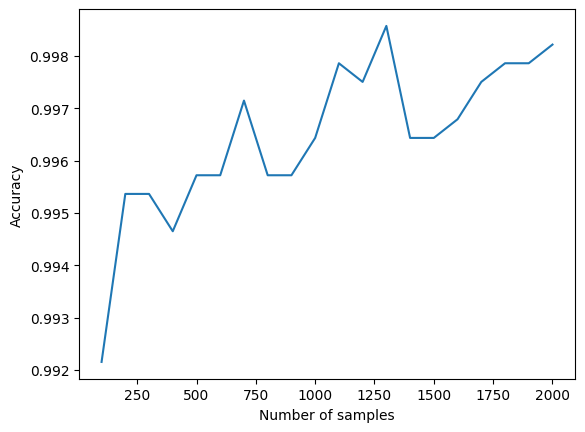

In [24]:
plt.plot(list(accuracies_Classical.keys()), list(accuracies_Classical.values()), label='Classical')
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.show()